# Installation details

Mind that if you want to use your GPU (Nvida CUDA compatible is needed), you
need to install the GPU version of the package along with CUDA, Nvidia's package
for interfacing between the user and the GPU, and cuDNN, a Deep Neural Network
base package.

- CUDA: http://www.nvidia.es/object/cuda-parallel-computing-es.html
- cuDNN: https://developer.nvidia.com/cudnn

Notice that training NN with CPU is slower than using GPU, even though
Keras/Tensorflow does some kind of paralelization of the operations using BLAS 
libraries (Basic Linear Algebra Subprograms). Therefore, GPU usage is advised 
for this session. But don't worry, the code for CPU and GPU is exactly the 
same except for one line where we define the execution.

# Loading the model

In [1]:
library(keras)
library(imager)

Loading required package: magrittr

Attaching package: 'imager'

The following object is masked from 'package:magrittr':

    add

The following objects are masked from 'package:stats':

    convolve, spectrum

The following object is masked from 'package:graphics':

    frame

The following object is masked from 'package:base':

    save.image



Loading Batch-Normalized Inception network

Reference:   
 - Batch normalization: Accelerating deep network training by reducing internal covariate shift(Loffe et al., 2015).
 
Based on Inceptionv3 network: rethinking the inception architecture for computer vision (Szegedy et al., 2015) https://arxiv.org/abs/1512.00567

In [4]:
model <- application_inception_v3(include_top = TRUE, weights = "imagenet",
  input_tensor = NULL, input_shape = c(299,299,3), pooling = NULL,
  classes = 1000)

Now we check the model:

In [5]:
model

Model
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_2 (InputLayer)      (None, 299, 299,  0                                   
________________________________________________________________________________
conv2d_95 (Conv2D)        (None, 149, 149,  864      input_2[0][0]              
________________________________________________________________________________
batch_normalization_95 (B (None, 149, 149,  96       conv2d_95[0][0]            
________________________________________________________________________________
activation_95 (Activation (None, 149, 149,  0        batch_normalization_95[0][0
________________________________________________________________________________
conv2d_96 (Conv2D)        (None, 147, 147,  9216     activation_95[0][0]        
________________________________________________________________________________
batch_normalization_96

# Load model's classes

The predictions of the network can be decoded with *imagenet_decode_predictions*, however we will use the original text file so we know how it is done.

In [6]:
synsets <- readLines("synset.txt")
length(synsets)
head(synsets)

[1] 1000

[1] "n01440764 tench, Tinca tinca"                                                                 
[2] "n01443537 goldfish, Carassius auratus"                                                        
[3] "n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias"
[4] "n01491361 tiger shark, Galeocerdo cuvieri"                                                    
[5] "n01494475 hammerhead, hammerhead shark"                                                       
[6] "n01496331 electric ray, crampfish, numbfish, torpedo"

# Image preprocess functions

In [71]:
# Image preprocess
preproc.image <- function(im, crop = TRUE, dims=3) {
  if (crop) {
    ## Crop the image so it gets same height and width
    shape <- dim(im)
    short.edge <- min(shape[1:2]) # Get the shorter edge from the picture
    # Calculate how much we should crop for each axis
    xx <- floor((shape[1] - short.edge) / 2) 
    yy <- floor((shape[2] - short.edge) / 2)
    im <- crop.borders(im, xx, yy) # Cropped image
  } 
  # Resize to 299 x 299, needed by input of the model.
  resized <- resize(im, 299, 299)
  # Convert to array (x, y, channel)
  arr <- (as.array(resized) - 0.5)*2 # Pixels between -1 and 1 (This is the normalization used in training)
  dim(arr) <- c(299, 299, 3)

  # Reshape to format needed by the network (num, width, height, channel)
  dim(arr) <- c(1,299, 299, 3)
  return(arr)
}

In [72]:
# Result printing
printClassRank <- function(prob, labels, nRes = 10) {
  nRes <- min(nRes, length(labels))
  o <- order(prob, decreasing=TRUE)
  res <- data.frame(class=synsets[o], probability=prob[o])
  head(res, n = nRes)
}

# Image classification

In [73]:
# Modifying plot area so that we can see the original photo and the preprocessed
#  photo
oldpar <- par() # We can save the old configuration using empty par()
par(mfrow=c(1,2))

## Starters: Take an image from imageR package - Give me macaws!

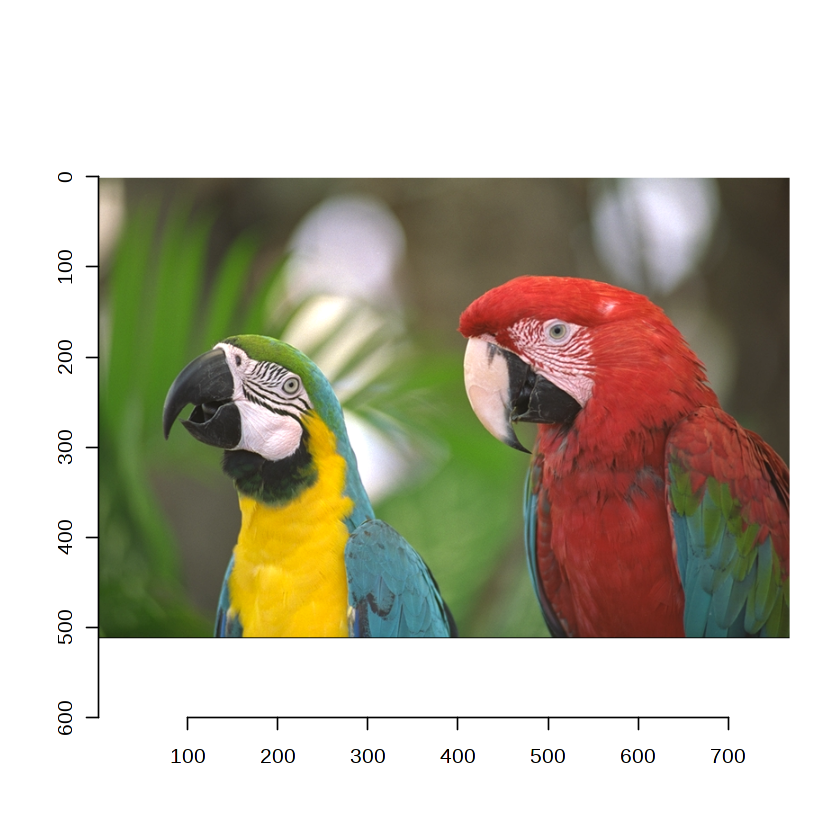

In [74]:
im <- load.image(system.file("extdata/parrots.png", package="imager"))
plot(im)

In [75]:
dim(im)

[1] 768 512   1   3

768x512 resolution with 3 channels (RGB), but this network was trained with images of size 224x224, we need to resize them.

Warning message in as.cimg.array(preproc[, , , ]):
"Assuming third dimension corresponds to colour"

[1]   1 299 299   3

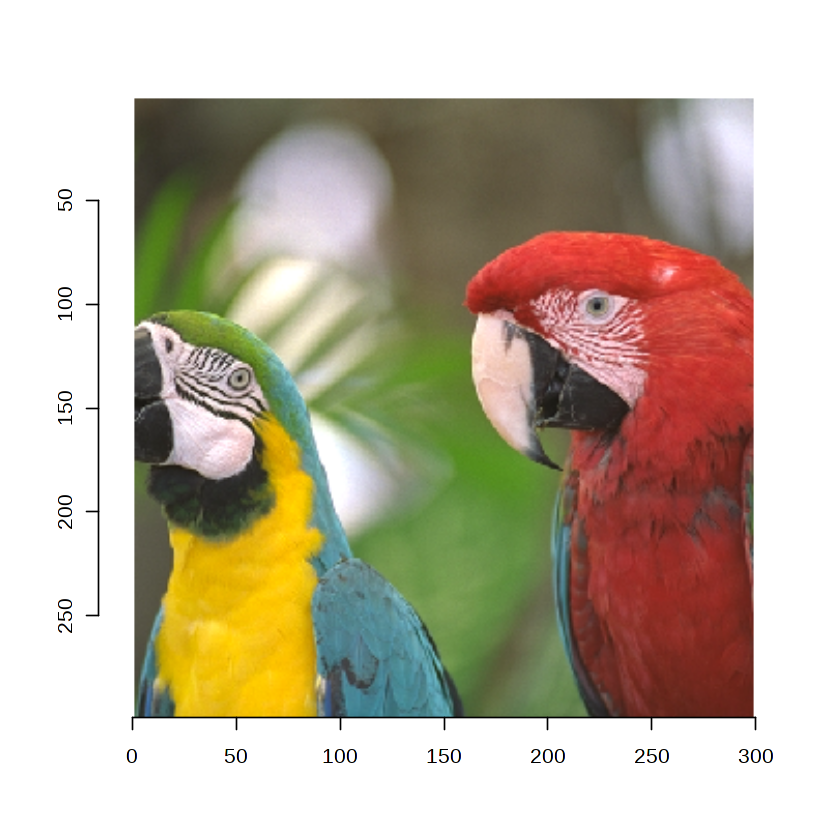

In [93]:
preproc <- preproc.image(im)
plot(as.cimg(preproc[,,,]))
dim(preproc)

We can observe that the image has been reduced, now has height = width and the image is cropped. Values are now between -1 and 1.

In [94]:
str(preproc)

 num [1, 1:299, 1:299, 1:3] -0.333 -0.349 -0.349 -0.349 -0.357 ...


Predict the parrots! In other words, get the class probabilities

In [95]:
prob <- predict(model, preproc)
dim(prob)

[1]    1 1000

We get 1000 probabilities,  one for each class. Now we check which are the most representative.

In [96]:
printClassRank(prob, synsets)

class                                                                 
1  n01818515 macaw                                                       
2  n01820546 lorikeet                                                    
3  n01817953 African grey, African gray, Psittacus erithacus             
4  n02007558 flamingo                                                    
5  n01843383 toucan                                                      
6  n01819313 sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita
7  n03127747 crash helmet                                                
8  n02128757 snow leopard, ounce, Panthera uncia                         
9  n02012849 crane                                                       
10 n03379051 football helmet                                             
   probability 
1  0.6544093490
2  0.0186850950
3  0.0049923691
4  0.0019017688
5  0.0017725008
6  0.0016499582
7  0.0011452826
8  0.0010587695
9  0.0009335988
10 0.0009322278

It's actually not a parrot but a Macaw and it gets correctly predicted!

## Now with something completely different: A laptop with Alpha Channel

[1] 573 430   1   4

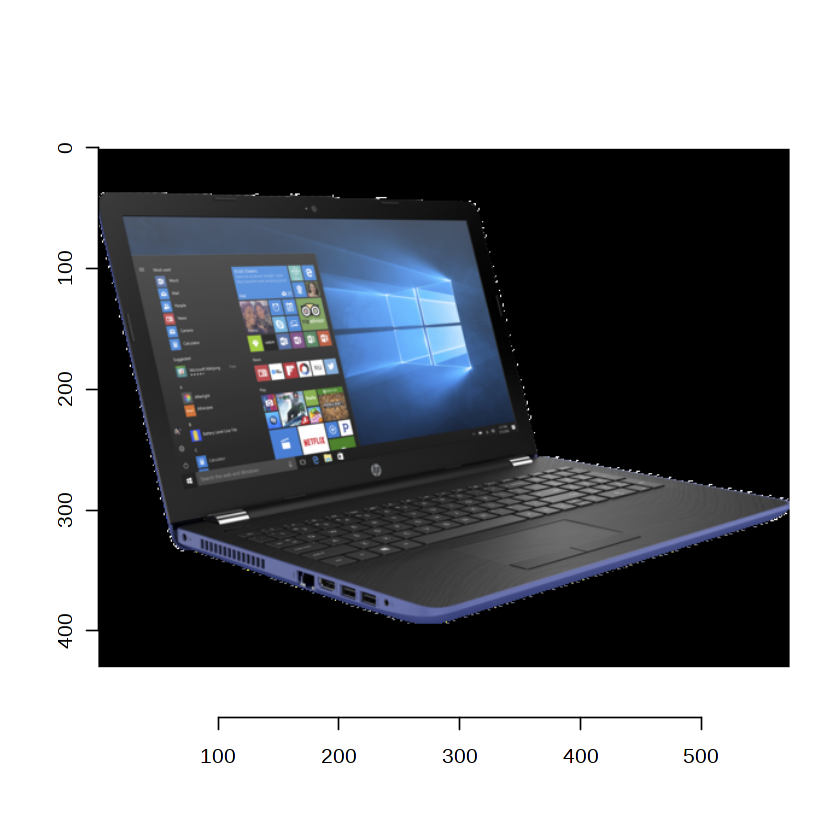

In [97]:
im2 <- load.image("images/laptop.png")
plot(im2)
dim(im2)

 572x430 with 4 channels... something is wrong.
 PNG format allows the image to have transparency using the well-known alpha
  channel. This channel marks how much transparency we need to use for each 
  pixel. We can remove it using rm.alpha function.

[1] 573 430   1   3

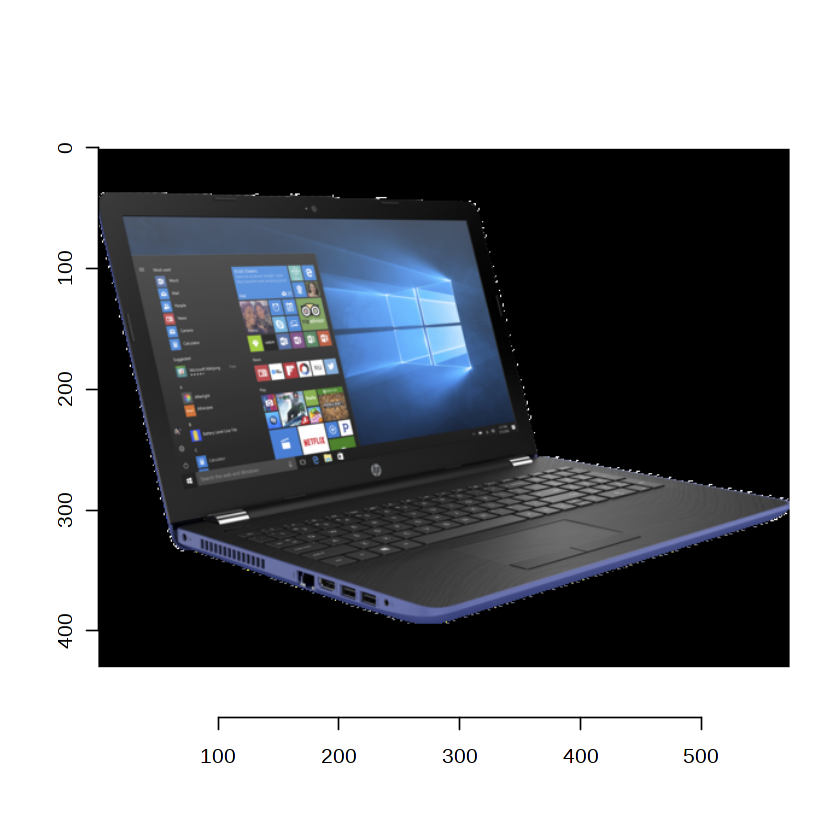

In [98]:
im2 <- rm.alpha(im2)
plot(im2)
dim(im2)

Now we have 3 channels, we can proceed as before.

Warning message in as.cimg.array(preproc[, , , ]):
"Assuming third dimension corresponds to colour"

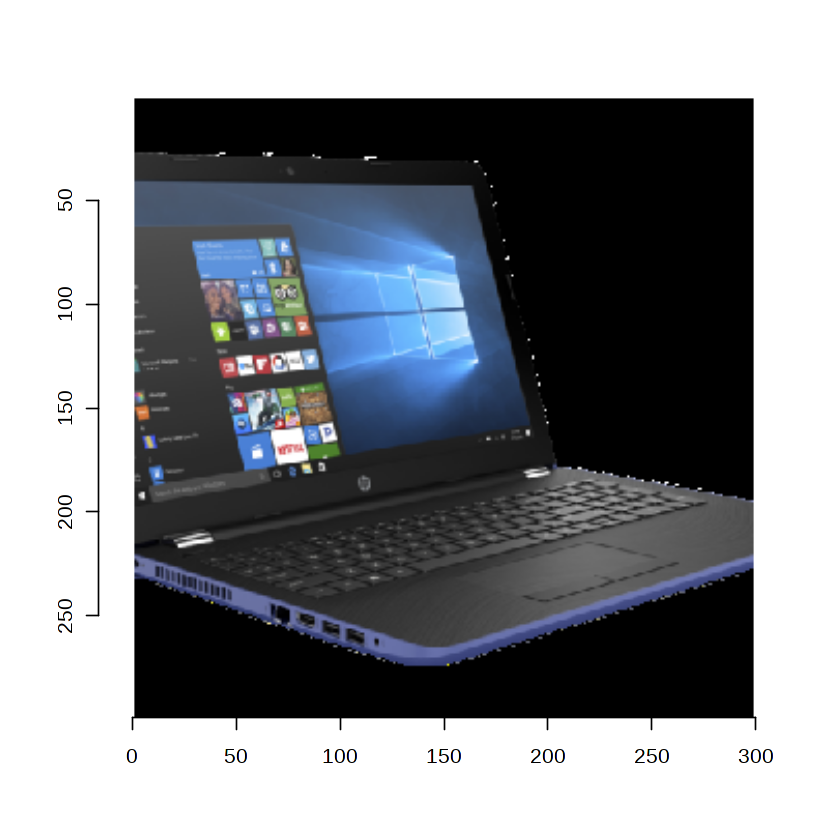

In [100]:
preproc <- preproc.image(im2)
plot(as.cimg(preproc[,,,]))

In [101]:
prob <- predict(model, preproc)
printClassRank(prob, synsets)

class                                                        probability
1  n03782006 monitor                                            0.660042644
2  n04152593 screen, CRT screen                                 0.155979887
3  n03180011 desktop computer                                   0.143689096
4  n03642806 laptop, laptop computer                            0.008392184
5  n03832673 notebook, notebook computer                        0.005269927
6  n03529860 home theater, home theatre                         0.001873044
7  n03085013 computer keyboard, keypad                          0.001839006
8  n03793489 mouse, computer mouse                              0.001700508
9  n04149813 scoreboard                                         0.001240686
10 n03857828 oscilloscope, scope, cathode-ray oscilloscope, CRO 0.000899285

Monitor, screen, desktop computer, laptop. Not bad.

## Picture proportion is important: Is the network aware of dinosaurs?

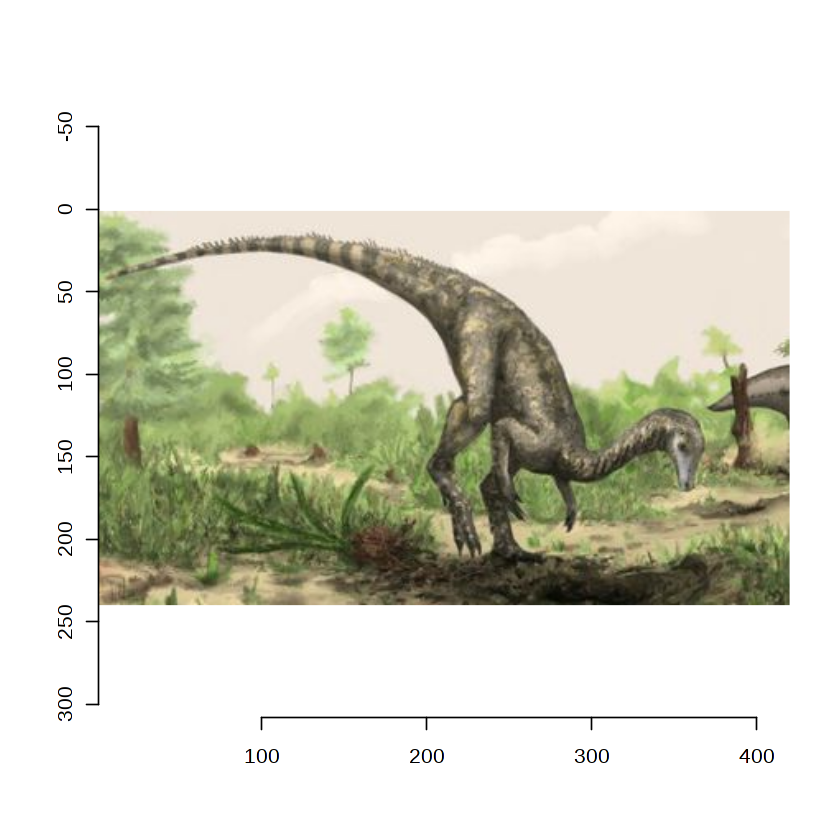

In [102]:
im3 <- load.image("images/dinosaur.jpg")
plot(im3)

Warning message in as.cimg.array(preproc[, , , ]):
"Assuming third dimension corresponds to colour"

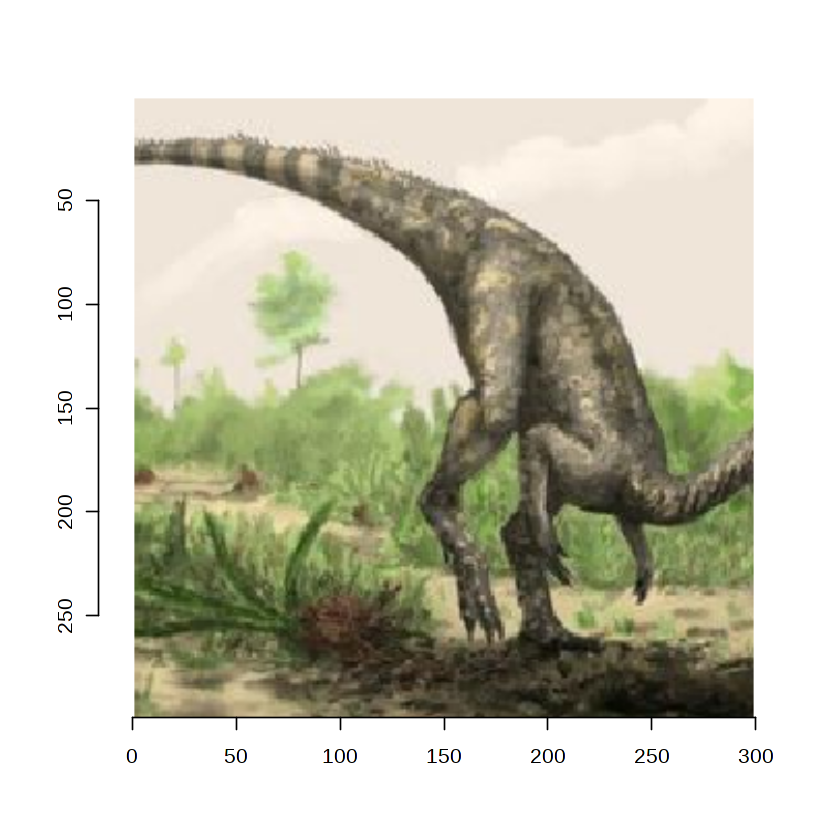

In [103]:
preproc <- preproc.image(im3)
plot(as.cimg(preproc[,,,]))
prob <- predict(model, preproc)

The head gets cut, does it matter?

In [104]:
printClassRank(prob, synsets)

class                                                                    
1  n01688243 frilled lizard, Chlamydosaurus kingi                           
2  n01694178 African chameleon, Chamaeleo chamaeleon                        
3  n01675722 banded gecko                                                   
4  n02457408 three-toed sloth, ai, Bradypus tridactylus                     
5  n01644900 tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
6  n01687978 agama                                                          
7  n02879718 bow                                                            
8  n01689811 alligator lizard                                               
9  n02500267 indri, indris, Indri indri, Indri brevicaudatus                
10 n01630670 common newt, Triturus vulgaris                                 
   probability
1  0.326780558
2  0.299931347
3  0.068925969
4  0.023125000
5  0.022452381
6  0.010997850
7  0.007947814
8  0.005979110
9  0.005354682
10 0.005207573

African Chamaleon. Almost!

 What happens if we resize without cropping the image so that the head is 
  preserved?

Warning message in as.cimg.array(preproc[, , , ]):
"Assuming third dimension corresponds to colour"

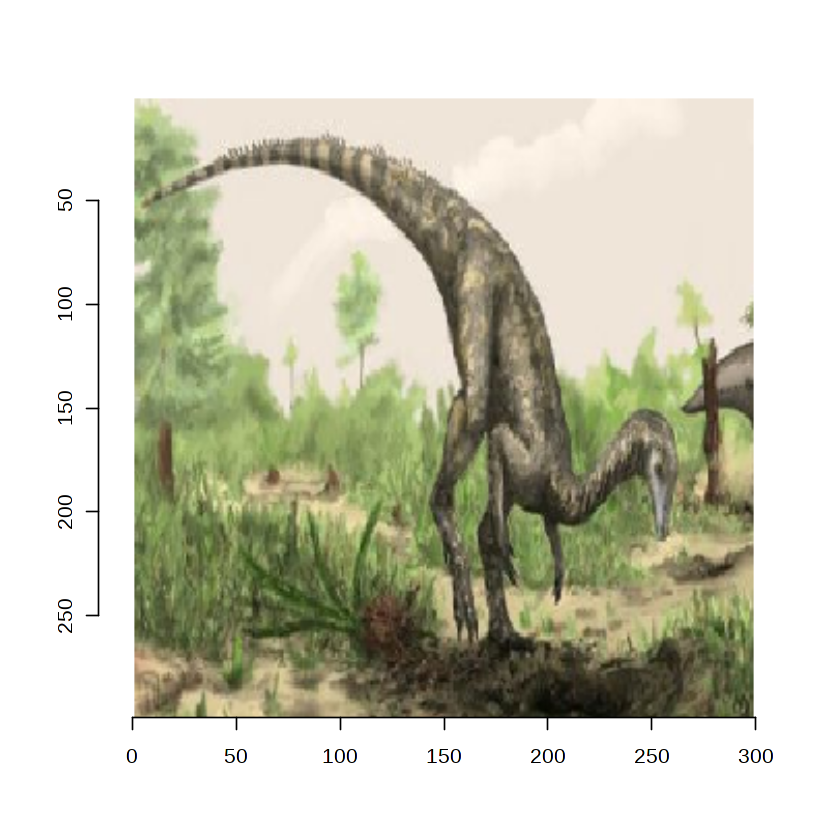

In [106]:
preproc <- preproc.image(im3, crop=FALSE)
plot(as.cimg(preproc[,,,]))
prob <- predict(model, preproc)

In [107]:
# Which class is the most representative
printClassRank(prob, synsets)
# Frilled lizard. The prediction changed, so the proportions of the image are important.

class                                                                    
1  n01688243 frilled lizard, Chlamydosaurus kingi                           
2  n01675722 banded gecko                                                   
3  n01694178 African chameleon, Chamaeleo chamaeleon                        
4  n01677366 common iguana, iguana, Iguana iguana                           
5  n01689811 alligator lizard                                               
6  n01687978 agama                                                          
7  n02879718 bow                                                            
8  n01644900 tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
9  n01698640 American alligator, Alligator mississipiensis                  
10 n01682714 American chameleon, anole, Anolis carolinensis                 
   probability
1  0.720620751
2  0.104003742
3  0.030216876
4  0.017132044
5  0.011024418
6  0.006645061
7  0.005944965
8  0.004173551
9  0.003145227
10 0.003021359

What if we center it manually?

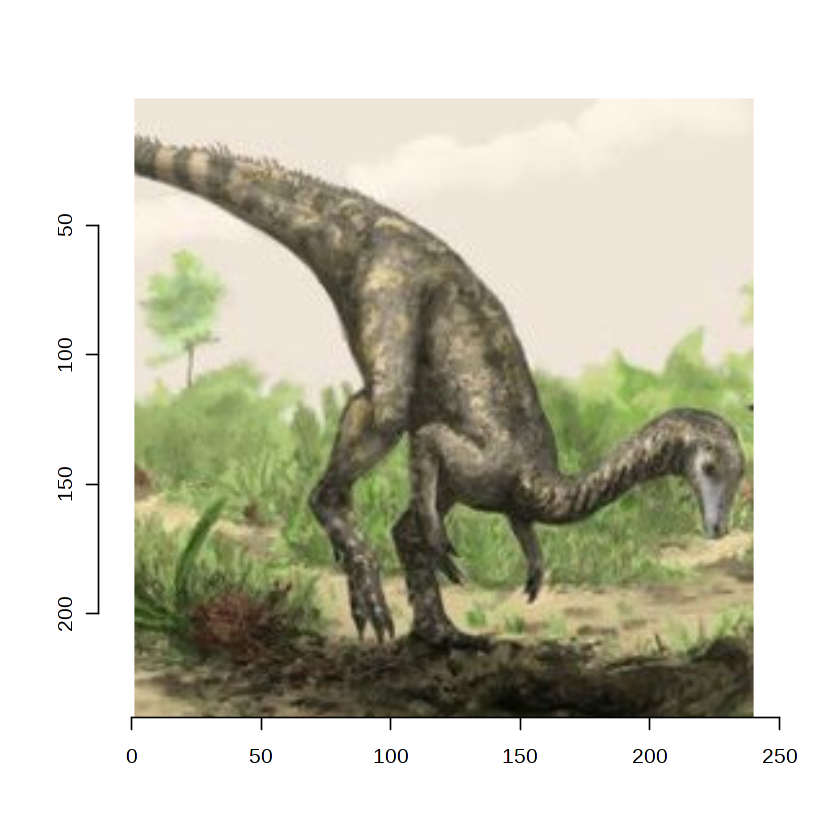

In [108]:
im3.2 <- load.image("images/dinosaurSquare.jpg")
plot(im3.2)

Warning message in as.cimg.array(preproc[1, , , ]):
"Assuming third dimension corresponds to colour"

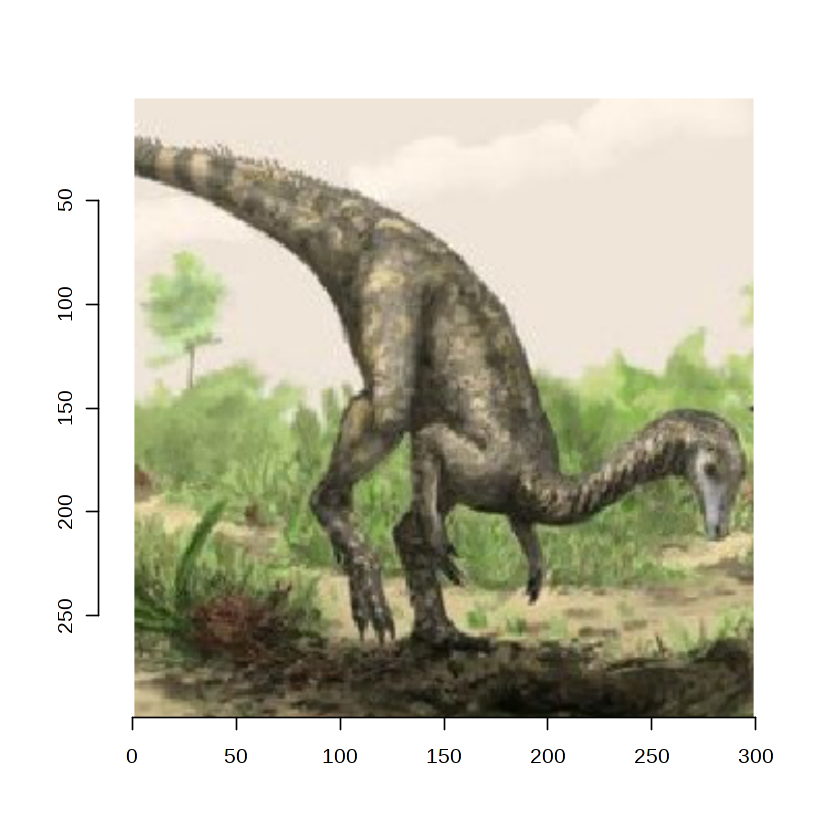

In [109]:
preproc <- preproc.image(im3.2)
plot(as.cimg(preproc[1,,,]))
prob <- predict(model, preproc)

In [59]:
printClassRank(prob, synsets)

class                                                                    
1  n01694178 African chameleon, Chamaeleo chamaeleon                        
2  n01688243 frilled lizard, Chlamydosaurus kingi                           
3  n01675722 banded gecko                                                   
4  n01687978 agama                                                          
5  n02457408 three-toed sloth, ai, Bradypus tridactylus                     
6  n01682714 American chameleon, anole, Anolis carolinensis                 
7  n01644900 tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
8  n02500267 indri, indris, Indri indri, Indri brevicaudatus                
9  n01689811 alligator lizard                                               
10 n01677366 common iguana, iguana, Iguana iguana                           
   probability
1  0.270068109
2  0.157671139
3  0.083946444
4  0.021566324
5  0.019916981
6  0.014364913
7  0.012171571
8  0.012092926
9  0.009442206
10 0.009255226

African Chamaleon still is the most representative 

## Can the network identify Agbar Tower?

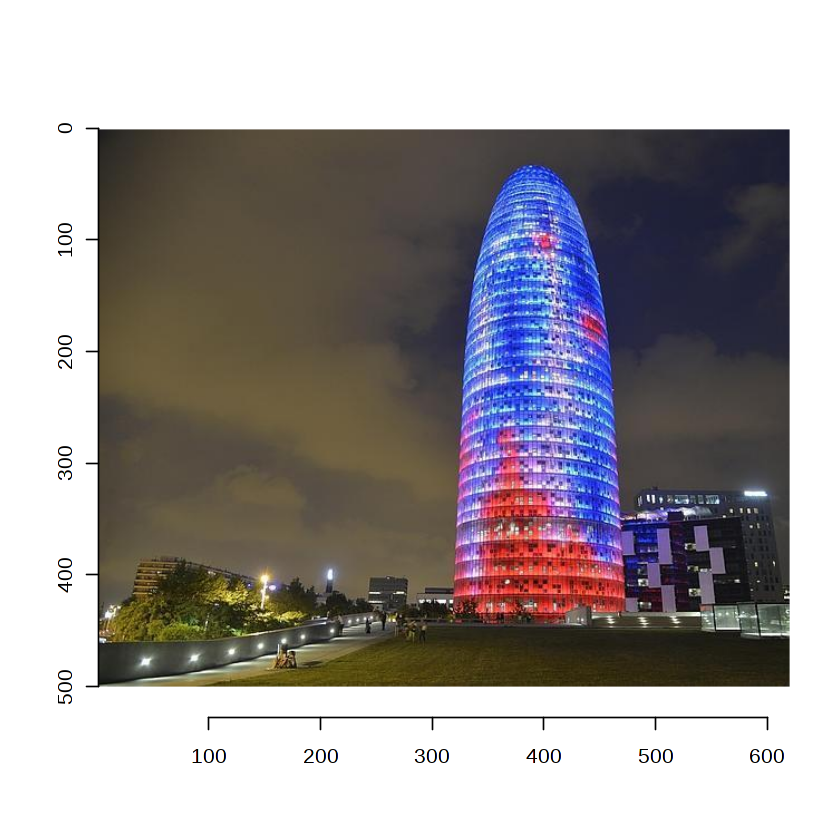

In [111]:
im4 <- load.image("images/agbar.jpg")
plot(im4)

Warning message in as.cimg.array(preproc[1, , , ]):
"Assuming third dimension corresponds to colour"

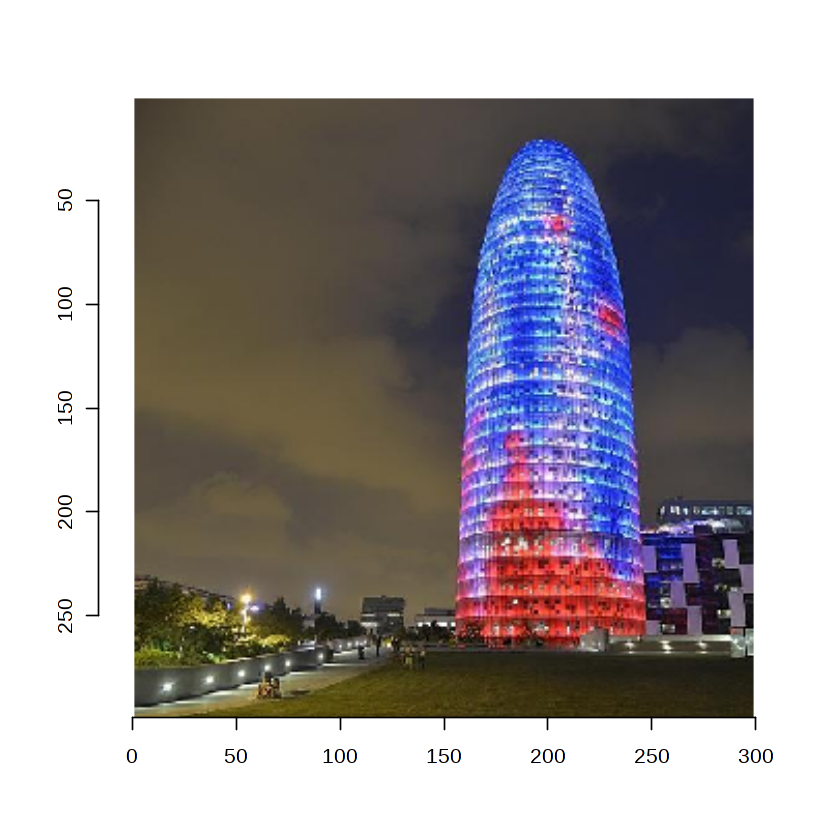

In [112]:
preproc <- preproc.image(im4)
plot(as.cimg(preproc[1,,,]))
prob <- predict(model, preproc)

In [113]:
printClassRank(prob, synsets)

class                                 probability
1  n04277352 spindle                     0.148714066
2  n04254777 sock                        0.074724309
3  n04067472 reel                        0.028994642
4  n04296562 stage                       0.027421901
5  n02804610 bassoon                     0.020592168
6  n03838899 oboe, hautboy, hautbois     0.013446912
7  n03976657 pole                        0.010576974
8  n04141076 sax, saxophone              0.010381553
9  n04599235 wool, woolen, woollen       0.009507323
10 n03249569 drum, membranophone, tympan 0.008706241

Spindle, sock... Almost. The network is not quite sure about what Agbar tower is.
We should ignore the classification, as the higher probability is very small. Maybe the colors are fooling the network, let's try without color.

Warning message in as.cimg.array(preproc[1, , , ]):
"Assuming third dimension corresponds to colour"

class                                                          probability
1  n04141076 sax, saxophone                                       0.13501789 
2  n03495258 harp                                                 0.13326302 
3  n02788148 bannister, banister, balustrade, balusters, handrail 0.10081862 
4  n03065424 coil, spiral, volute, whorl, helix                   0.07746976 
5  n02804610 bassoon                                              0.03745870 
6  n03838899 oboe, hautboy, hautbois                              0.03606398 
7  n04153751 screw                                                0.02480378 
8  n02787622 banjo                                                0.01503362 
9  n04487394 trombone                                             0.01327600 
10 n03110669 cornet, horn, trumpet, trump                         0.01120354

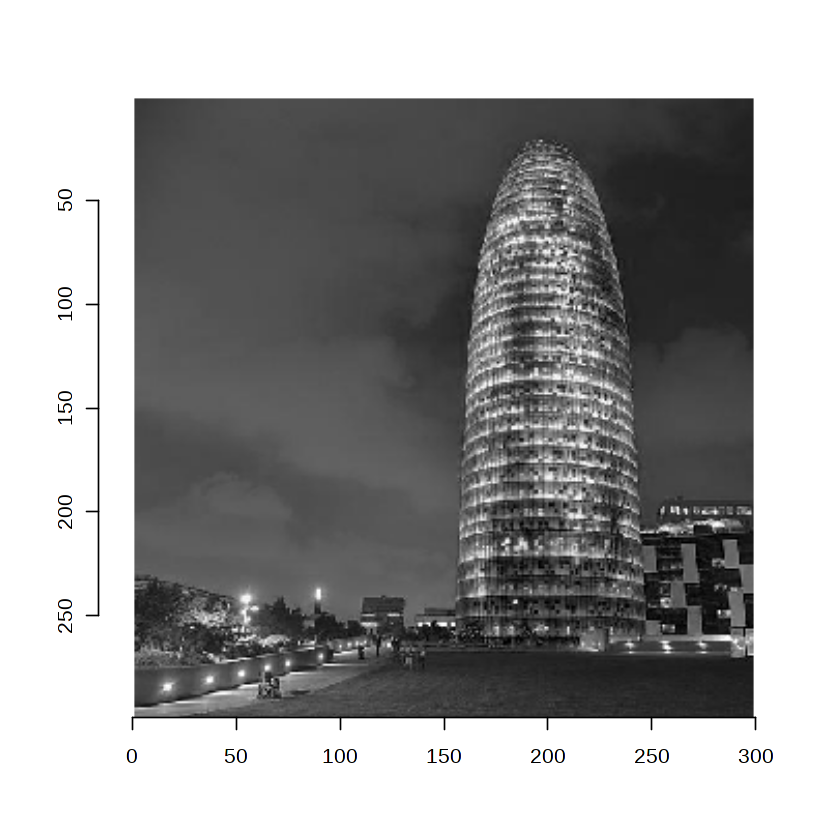

In [125]:
preproc <- preproc.image(im4)
preproc <- preproc[1,,,c(2,2,2), drop=F] # Grayscale (setting all the channels to the same value)
plot(as.cimg(preproc[1,,,]))
prob <- predict(model, preproc[1,,,c(1,1,1), drop=F])
printClassRank(prob, synsets)

It's not the color, it gets classified as a saxophone.

## Agbar 2: Let's try with another photo

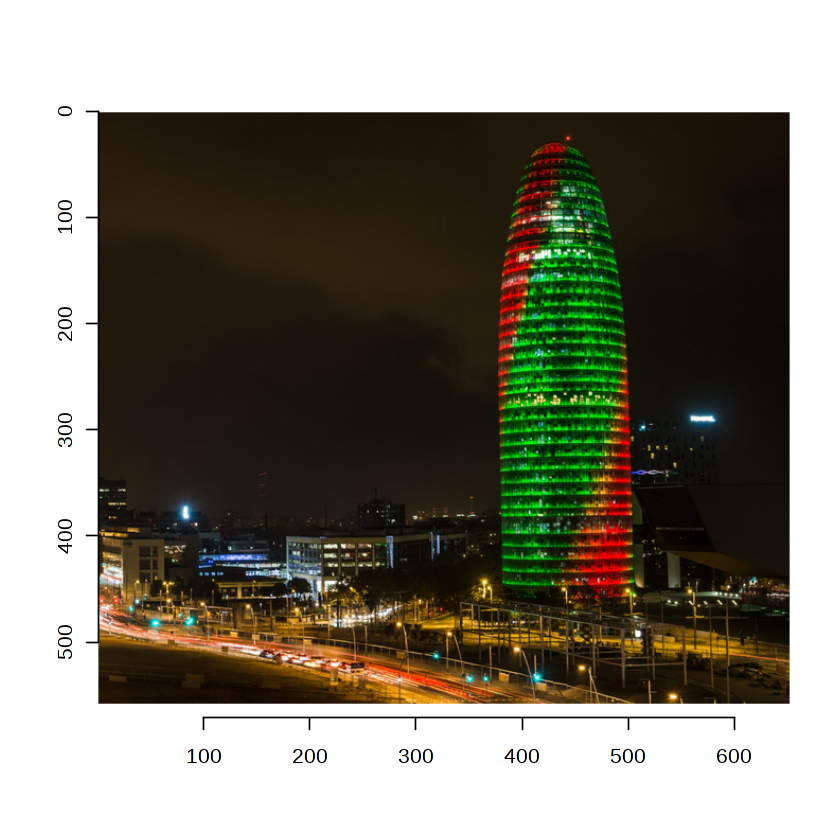

In [126]:
im5 <- load.image("images/Agbar2.png")
plot(im5)

Warning message in as.cimg.array(preproc[1, , , ]):
"Assuming third dimension corresponds to colour"

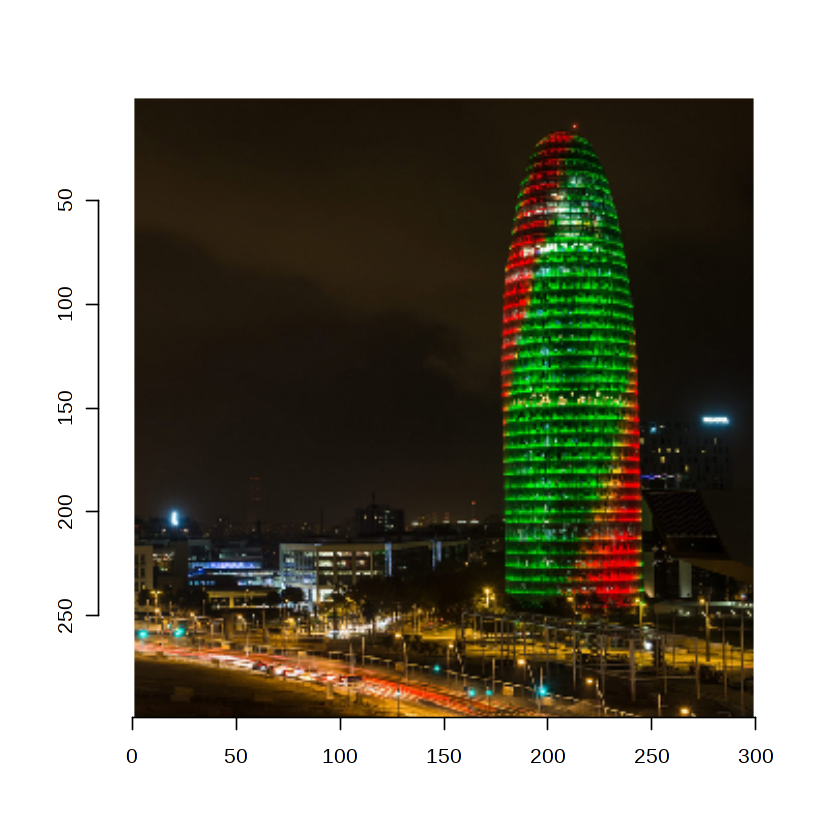

In [127]:
preproc <- preproc.image(im5)
plot(as.cimg(preproc[1,,,]))
prob <- predict(model, preproc)

In [128]:
printClassRank(prob, synsets)

class                                                                      
1  n03637318 lampshade, lamp shade                                            
2  n04366367 suspension bridge                                                
3  n04141076 sax, saxophone                                                   
4  n03388043 fountain                                                         
5  n01930112 nematode, nematode worm, roundworm                               
6  n04296562 stage                                                            
7  n04418357 theater curtain, theatre curtain                                 
8  n03032252 cinema, movie theater, movie theatre, movie house, picture palace
9  n02782093 balloon                                                          
10 n04254777 sock                                                             
   probability
1  0.053805571
2  0.025773792
3  0.017962690
4  0.014260580
5  0.012751474
6  0.008149481
7  0.008111350
8  0.007397199
9  0.007117193
10 0.006699307

The network is still not clear about what is that photo. Probably the bigest lampshade on planet Earth.

## Identifying by aesthetics: You may know what is this one

Warning message in readfun(f, ...):
"libpng warning: iCCP: known incorrect sRGB profile"

[1] 800 558   1   4

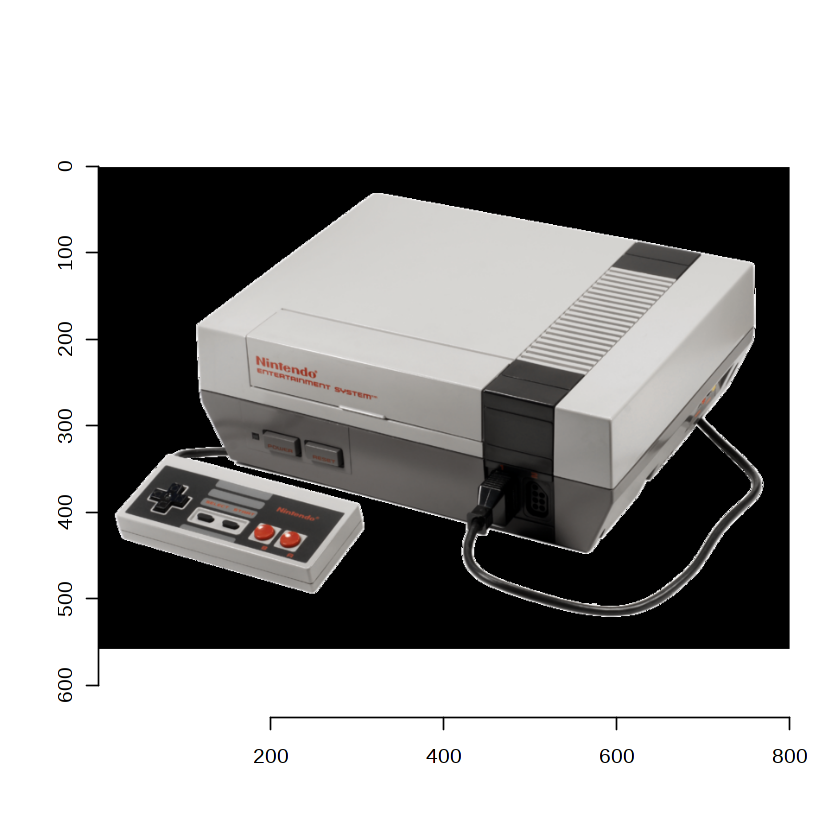

In [130]:
im6 <- load.image("images/NES.png")
dim(im6)
# Notice that this image has 4 channels!
plot(im6)

In [131]:
# Remove Alpha Channel
im6 <- rm.alpha(im6)

Warning message in as.cimg.array(preproc[, , , ]):
"Assuming third dimension corresponds to colour"

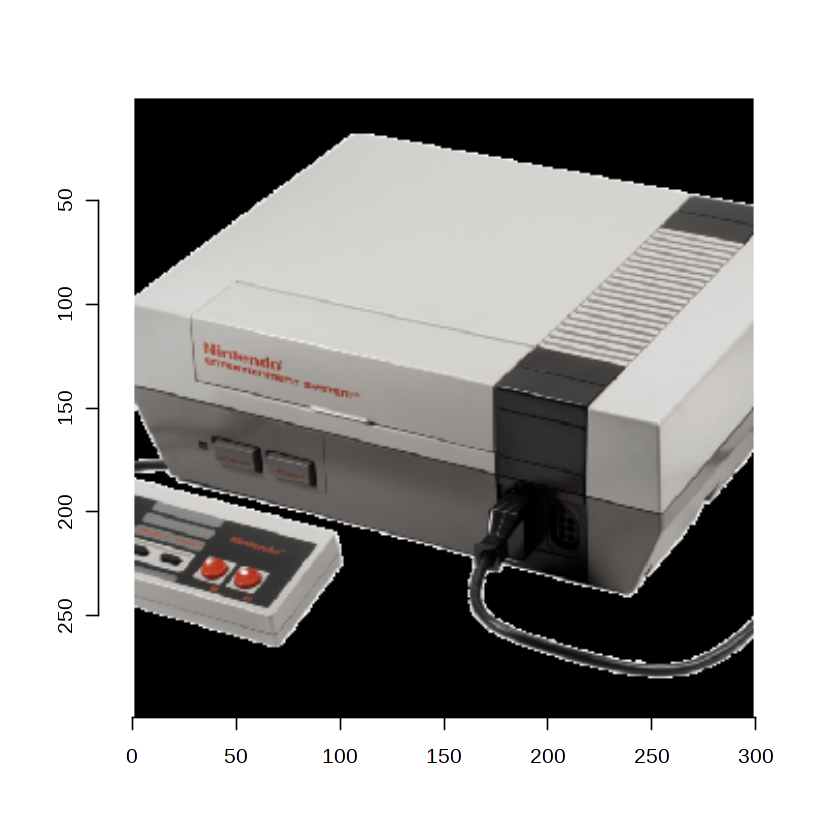

In [132]:
preproc <- preproc.image(im6)
plot(as.cimg(preproc[,,,]))
prob <- predict(model, preproc)

In [69]:
printClassRank(prob, synsets)

class                                           probability
1  n03777754 modem                                 0.19551541 
2  n03782006 monitor                               0.10794843 
3  n04152593 screen, CRT screen                    0.06946526 
4  n03976467 Polaroid camera, Polaroid Land camera 0.05962937 
5  n04404412 television, television system         0.05094223 
6  n03924679 photocopier                           0.04266527 
7  n02979186 cassette player                       0.03596348 
8  n04004767 printer                               0.03188616 
9  n03297495 espresso maker                        0.03042920 
10 n04009552 projector                             0.01736374

 Modem, cassette player, CRT screen... An hypothesis on this is that it is recognizing the 
  aesthetics of that time this console was built.